In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


## check data stack size

In [24]:
## datastack sizes 
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:7]  # Select the first 8 experiment names

dfnan2 = pd.DataFrame(columns=['Experiment', 'NanPercentAllowed', 'NumPatches', 'TotalPixels'])
for exp_name in experiment_names:
    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    cfg.update(global_config)  # Ensure cfg has the latest global_config
    print("=== EXPERIMENT ===")
    print(f" --> Name: {exp_name}")

    for nan_percent_allowed in [0, 4, 8, 12, 16, 20, 30, 40]:
        print(f"--- {exp_name}, nan pc: {nan_percent_allowed} ---")
        # Build dataset
        X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32, nan_percent_allowed=nan_percent_allowed)
        num_patches = len(X)
        total_pixels = num_patches * 32 * 32
        dfnan2 = pd.concat([dfnan2, pd.DataFrame([{'Experiment': exp_name, 
                             'NanPercentAllowed': nan_percent_allowed,
                             'NumPatches': num_patches,
                             'TotalPixels': total_pixels}])], ignore_index=True)
        print(f"Num patches: {num_patches}, Total pixels: {total_pixels}")
        #print(f"Data stack X shape: {X.shape}, Y shape: {Y.shape}")
    print("==========")

=== EXPERIMENT ===
 --> Name: 01_baseline
--- 01_baseline, nan pc: 0 ---
Site SITE1: extracted 358 patches.
Site SITE2: extracted 309 patches.
Site SITE3: extracted 106 patches.
Num patches: 773, Total pixels: 791552
--- 01_baseline, nan pc: 4 ---
Site SITE1: extracted 427 patches.
Site SITE2: extracted 369 patches.
Site SITE3: extracted 255 patches.
Num patches: 1051, Total pixels: 1076224
--- 01_baseline, nan pc: 8 ---
Site SITE1: extracted 440 patches.
Site SITE2: extracted 381 patches.
Site SITE3: extracted 348 patches.
Num patches: 1169, Total pixels: 1197056
--- 01_baseline, nan pc: 12 ---
Site SITE1: extracted 451 patches.
Site SITE2: extracted 393 patches.
Site SITE3: extracted 416 patches.
Num patches: 1260, Total pixels: 1290240
--- 01_baseline, nan pc: 16 ---
Site SITE1: extracted 458 patches.
Site SITE2: extracted 399 patches.
Site SITE3: extracted 485 patches.
Num patches: 1342, Total pixels: 1374208
--- 01_baseline, nan pc: 20 ---
Site SITE1: extracted 461 patches.
Site S

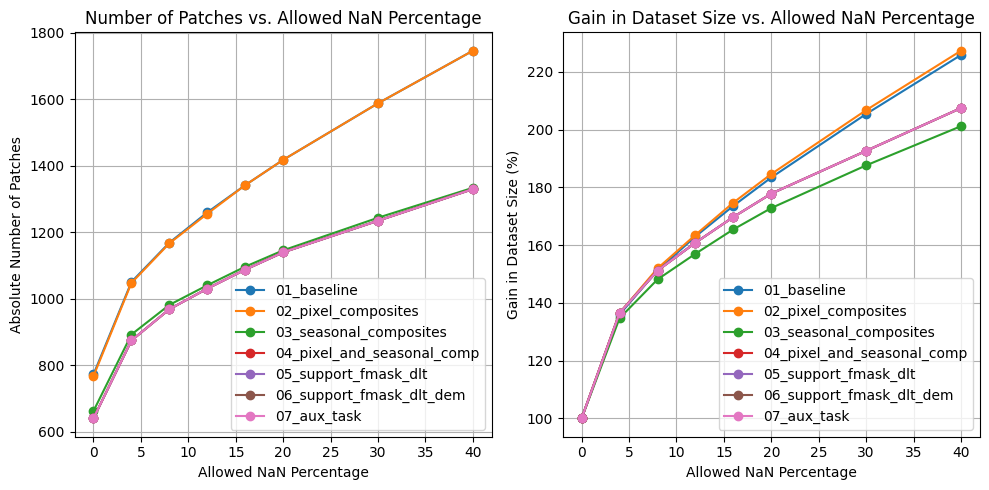

In [25]:
# plot the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Number of Patches vs. Allowed NaN Percentage
axes[0].set_title("Number of Patches vs. Allowed NaN Percentage")
for exp_name in experiment_names:
    if exp_name == "08_pretrained_encoder":  # Skip this experiment
        continue
    subset = dfnan2[dfnan2['Experiment'] == exp_name]
    axes[0].plot(subset['NanPercentAllowed'], subset['NumPatches'], marker='o', label=exp_name)

axes[0].set_xlabel("Allowed NaN Percentage")
axes[0].set_ylabel("Absolute Number of Patches")
axes[0].legend()
axes[0].grid()

# Plot Gain vs. Allowed NaN Percentage
axes[1].set_title("Gain in Dataset Size vs. Allowed NaN Percentage")
for exp_name in experiment_names:
    if exp_name == "08_pretrained_encoder":  # Skip this experiment
        continue
    subset = dfnan2[dfnan2['Experiment'] == exp_name]
    baseline_patches = int(subset[subset['NanPercentAllowed'] == 0]['NumPatches'].iloc[0])
    gain = subset['NumPatches'].astype(int) / baseline_patches * 100
    axes[1].plot(subset['NanPercentAllowed'], gain, marker='o', label=exp_name)

axes[1].set_xlabel("Allowed NaN Percentage")
axes[1].set_ylabel("Gain in Dataset Size (%)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

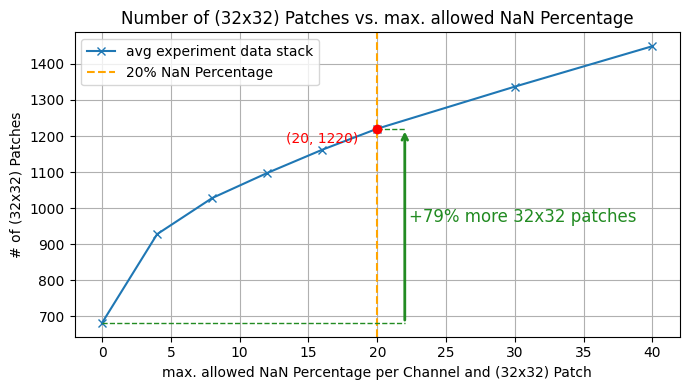

In [65]:
# Convert columns to numeric for calculations
dfnan2['NanPercentAllowed'] = pd.to_numeric(dfnan2['NanPercentAllowed'])
dfnan2['NumPatches'] = pd.to_numeric(dfnan2['NumPatches'])

# Calculate the average number of patches for each NanPercentAllowed
avg_patches = dfnan2.groupby('NanPercentAllowed')['NumPatches'].mean()

# Extract data for 20% NanPercentAllowed
nan_20_data = dfnan2[dfnan2['NanPercentAllowed'] == 20].groupby('NanPercentAllowed')['NumPatches'].mean()

# Plot the results
plt.figure(figsize=(7, 4))

# Plot the average line
plt.plot(avg_patches.index, avg_patches.values, label='avg experiment data stack', marker='x')

# Plot the line for 20% NanPercentAllowed
plt.axvline(x=20, color='orange', linestyle='--', label='20% NaN Percentage')

# Annotate the intersection point
intersection_x = 20
intersection_y = avg_patches.loc[20]
plt.scatter(intersection_x, intersection_y, color='red', zorder=5)
plt.annotate(f"({intersection_x}, {intersection_y:.0f})", 
             (intersection_x, intersection_y), 
             textcoords="offset points", 
             xytext=(-40, -10), 
             ha='center', 
             fontsize=10, 
             color='red')
# Annotate an arrow from 0% tolerance to 20% tolerance
start_x = 22
start_y = avg_patches.loc[0]
end_x = 22
end_y = avg_patches.loc[20]

plt.annotate(
    "", 
    xy=(end_x, end_y), 
    xytext=(start_x, start_y), 
    arrowprops=dict(arrowstyle="->", color="forestgreen", lw=2)
)

plt.plot([0, 22], [avg_patches.loc[0], avg_patches.loc[0]], linestyle="--", color="forestgreen", lw=1)
plt.plot([20, 22], [avg_patches.loc[20], avg_patches.loc[20]], linestyle="--", color="forestgreen", lw=1)
# Calculate the percentage increase
percentage_increase = ((end_y - start_y) / start_y) * 100

# Annotate the percentage increase
plt.text(
    (end_x+0.3), 
    (start_y + end_y) / 2, 
    f"+{percentage_increase:.0f}% more 32x32 patches", 
    color="forestgreen", 
    fontsize=12, 
    ha="left", 
    va="bottom"
)

# Add labels, legend, and title
plt.xlabel("max. allowed NaN Percentage per Channel and (32x32) Patch")
plt.ylabel("# of (32x32) Patches")
plt.title("Number of (32x32) Patches vs. max. allowed NaN Percentage")
plt.legend()
plt.grid()

plt.tight_layout()

# save figure 
output_folder = "../data/10_insights/patches/"
# create folder
os.makedirs(os.path.dirname(output_folder), exist_ok=True)
plt.savefig(f"{output_folder}patches_avg_vs_nan_percentage.png", dpi=300)
plt.savefig(f"{output_folder}patches_avg_vs_nan_percentage.pdf", dpi=300)
plt.show()

## main run of experiments

In [35]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:7]  # Select the first 6 experiment names
    experiment_names = [#'01_baseline',
                        '02_pixel_composites',
                        '03_seasonal_composites',
                        #'04_pixel_and_seasonal_comp',
                        '05_support_fmask_dlt',
                        #'06_support_fmask_dlt_dem',
                        #'07_aux_task',
                        ]
    
with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']
#print(experiment_names)
experiment_names

['02_pixel_composites', '03_seasonal_composites', '05_support_fmask_dlt']

In [36]:
import random

global_config = md.global_config
# reproducible shuffling (num_workers=0 -> simpler)
seed = global_config['seed']
run_id_base = "251021_N"
repetitions = 2


for i in range(repetitions): # Run 10 experiments with different seeds
    #run_id = md.generate_run_id()
    run_id = run_id_base + f"_{i}"
    seed = seed + i  # Different seed for each experiment
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    for exp_name in experiment_names:
        
        sites, cfg = cf.get_config(exp_name)  
        cfg.update(global_config)  # Ensure cfg has the latest global_config
        print("=== NEW EXPERIMENT ===")
        print(f" --> Name: {exp_name}")

        # Build dataset
        X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32, nan_percent_allowed=20)
        
        # split into train/val/test (70/15/15) with your logic
        (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y, seed=seed)

        # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
        train_dataset = md.S2CanopyHeightDataset(X_train, Y_train, cfg)
        val_dataset = md.S2CanopyHeightDataset(X_val, Y_val, cfg)
        test_dataset = md.S2CanopyHeightDataset(X_test, Y_test, cfg)

        train_loader = md.DataLoader(
            train_dataset,
            batch_size=global_config['batch_size'],
            shuffle=True,
            num_workers=0
        )
        val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
        test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
        
        if False:
            print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
            print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
            print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")
        
        # build model depending on in out channels, defined by the dataloaders
        model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
        #train model depending on config. 
        model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

        md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg, run_id=run_id)

        #eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
        #print("Minimum Validation Loss: ", min(logs['val_loss']))
        #print("DONE WITH ", exp_name)
        print("=================")
    print("DONE WITH ALL EXPERIMENTS for iteration ", i)

=== NEW EXPERIMENT ===
 --> Name: 02_pixel_composites


Epochs: 100%|██████████| 500/500 [07:45<00:00,  1.07it/s]


Results saved to: ../results/251021_N_0/train/02_pixel_composites
=== NEW EXPERIMENT ===
 --> Name: 03_seasonal_composites


Epochs:  86%|████████▌ | 428/500 [05:25<00:54,  1.31it/s]

Early stopping triggered at epoch 429


Results saved to: ../results/251021_N_0/train/03_seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: 05_support_fmask_dlt


Epochs:  84%|████████▍ | 419/500 [05:53<01:08,  1.19it/s]

Early stopping triggered at epoch 420


Results saved to: ../results/251021_N_0/train/05_support_fmask_dlt
DONE WITH ALL EXPERIMENTS for iteration  0
=== NEW EXPERIMENT ===
 --> Name: 02_pixel_composites


Epochs: 100%|██████████| 500/500 [07:43<00:00,  1.08it/s]


Results saved to: ../results/251021_N_1/train/02_pixel_composites
=== NEW EXPERIMENT ===
 --> Name: 03_seasonal_composites


Epochs: 100%|██████████| 500/500 [06:15<00:00,  1.33it/s]


Results saved to: ../results/251021_N_1/train/03_seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: 05_support_fmask_dlt


Epochs:  82%|████████▏ | 408/500 [05:41<01:16,  1.20it/s]

Early stopping triggered at epoch 409


Results saved to: ../results/251021_N_1/train/05_support_fmask_dlt
DONE WITH ALL EXPERIMENTS for iteration  1
